# DESeq2 DE Analysis Pipeline
- 依赖包:
   - DESeq2
   - RColorBrewer
   - gplots
   - pheatmap
   - ggplot2
- DESeq2对于输入数据的要求
   - 输入数据为整数构成的矩阵
   - 此矩阵必须是没有经过标准化(归一化/Normalize) 
- DESeq2进行差异表达分析
   - 构建dds矩阵
       ```
       dds <- DESeqDataSetFromMatrix(
                   countData = cts, 
                   colData = coldata, 
                   design= ~ batch + condition) 
       #~在R里面用于构建公式对象，~左边为因变量，右边为自变量。
       ```

   - 标准化/归一化
       ```
       dds <- DESeq(dds) 
       #标准化
       ```
   - 差异分析
       ```
       res <- results(dds, contrast=c("condition","treated","control")) 
       #差异分析结果
       ```

In [234]:
### read data ------------------------------------------------------------------------------>
rawcts <- read.table("../featureCounts/all_feature_fix.csv",header = TRUE,row.names = 1)

# vs1
# colData <- read.table("sample-NC_vs_CCNB1.csv",header = TRUE)
# rawcts <- rawcts[,c(1,2,3,4,5,6)]
colData <- read.table("sample-NC_vs_PUS7.csv",header = TRUE)
rawcts <- rawcts[,c(1,2,3,7,8,9)]

dim(rawcts)

[1] 11930     6

In [235]:
head(rawcts,4)

,NC1,NC2,NC3,PUS71,PUS72,PUS73
,<int>,<int>,<int>,<int>,<int>,<int>
WASH7P,602,520,415,404,442,466
LOC729737,456,362,335,372,432,462
MIR12136,1423,1778,2292,3055,3109,3044
LOC100288069,472,539,399,384,437,467


1. 读取样本信息（sample.txt）
2. 读取featureCounts产生的各个bam文件的counts信息
3. 检查rawcts中的所有记录(row)的个数，这里代表count到的gene的个数, geneid被指定为row.names了所以不计在内

In [236]:
# 21653 transcripts, 104 exps
dim(rawcts)

[1] 11930     6

In [237]:
# 看一下colData
# 样本名称、处理条件
colData

sample,condition,type
<chr>,<chr>,<chr>
NC1,NC,ctrl
NC2,NC,ctrl
NC3,NC,ctrl
PUS71,PUS7,treat
PUS72,PUS7,treat
PUS73,PUS7,treat


In [238]:
# 看一下rawcts
# 这个很简单就是geneid为index，样本信息的counts数为columns
head(rawcts)

,NC1,NC2,NC3,PUS71,PUS72,PUS73
,<int>,<int>,<int>,<int>,<int>,<int>
WASH7P,602,520,415,404,442,466
LOC729737,456,362,335,372,432,462
MIR12136,1423,1778,2292,3055,3109,3044
LOC100288069,472,539,399,384,437,467
LINC00115,27,25,22,29,20,21
LINC01128,425,409,322,205,210,264


4. 过滤掉行的和为0，也就是没有bam文件中count到reads的genes

In [239]:
### filt genes that don't express in all sample -------------------------------------------->
#  其实不用过滤了，step3过滤了RPKM >= 1
rawcts <- rawcts[rowSums(rawcts)>0,]
dim(rawcts)

[1] 11930     6

5. rownames函数调用矩阵的row.names
6. 调用stringr package中的str_split函数，去除geneid中的gene名的.以及后面的内容
7. 使用duplicated函数去掉重复的gn id   
   - 去重63个

In [240]:
### remove version in ensembl id ----------------------------------------------------------->
gn <- stringr::str_split(rownames(rawcts),"\\.",simplify = T)[,1]
# gene_id如果已经是name，name这个也做不做无所谓↑
# remove duplicate
rawcts <- rawcts[!duplicated(gn),]
rownames(rawcts) <- gn[!duplicated(gn)]
dim(rawcts)

[1] 11929     6

## 1. 构建dds矩阵

8. 将count的矩阵输入DESeq2的DESeqDataSetFromMatrix函数中，产生dds(DEseq Data Set)


构建dds矩阵需要：

- 表达矩阵
   - 即上述代码中的countData，就是我们前面通过read count计算后并融合生成的矩阵，行row为各个基因，列col为各个样品，中间为计算reads或者fragment得到的整数。我们后面要用的是这个文件（mouse_all_count.txt）
- 样品信息
   - 矩阵即上述代码中的colData，它的类型是一个dataframe（数据框），这个东西叫【元数据】
   - 第一列是样品名称，
   - 第二列是样品的处理情况（对照还是处理等），即condition，condition的类型是一个factor
   - 第三列type可以理解为宏观的处理条件，需要时使用，用不着也可以留空
   
   - 这里我用第三列的type作为自变量(你也可以用第二列的condition)
- 差异比较矩阵
   - 即上述代码中的design。
   - 差异比较矩阵就是告诉差异分析函数是要分析哪些变量间的差异
   - 简单说就是说明哪些是对照哪些是处理。

In [241]:
# colData
# rawcts

In [242]:
### DEseq analyses ------------------------------------------------------------------------->
library(DESeq2)
dds <- DESeqDataSetFromMatrix(countData = rawcts,
                              colData = colData,
                              design = ~ condition) 
                            # ~在R里面用于构建公式对象，~左边为因变量(design)，右边为自变量(type/condition) 
dds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 11929 6 
metadata(1): version
assays(1): counts
rownames(11929): WASH7P LOC729737 ... RPL23AP82 RABL2B
rowData names(0):
colnames(6): NC1 NC2 ... PUS72 PUS73
colData names(3): sample condition type

In [243]:
# 预过滤 【不做】
# 虽然不必在运行DESeq2函数之前对低计数基因进行预过滤，但是有两个原因使预过滤有用：
# - 通过删除读取次数很少的行，我们减小了dds数据对象的内存大小，并且我们提高了DESeq2中转换和测试功能的速度。
# - 在这里，我们执行最小的预过滤，以仅保留总读取次数至少为10的行。
# - 请注意，对结果函数中的归一化计数的平均值进行独立滤波后，会自动应用更严格的滤波以增加功率。

# keep <- rowSums(counts(dds)) >= 10
# dds <- dds[keep,]
# dds

9. 将dds输入DESeq函数#原始dds进行normalize
DESeq包含三步:
- estimation of size factors（estimateSizeFactors)
- estimation of dispersion（estimateDispersons)
- Negative Binomial GLM fitting and Wald statistics（nbinomWaldTest）
- 【可以分布运行，也可用一步到位，最后返回 results可用的DESeqDataSet对象。】

In [244]:
dds <- DESeq(dds)
dds

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 11929 6 
metadata(1): version
assays(4): counts mu H cooks
rownames(11929): WASH7P LOC729737 ... RPL23AP82 RABL2B
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(6): NC1 NC2 ... PUS72 PUS73
colData names(4): sample condition type sizeFactor

10. Plot Dispersion Estimates
- 观察数据的离散情况
- A simple helper function that plots the per-gene dispersion estimates together with the fitted mean-dispersion relationship.

Arguments
- object
   - a DESeqDataSet, with dispersions estimated
- ymin
   - the lower bound for points on the plot, points beyond this are drawn as triangles at ymin
- genecol
   - the color for gene-wise dispersion estimates
- fitcol
   - the color of the fitted estimates
- finalcol
   - the color of the final estimates used for testing
- legend
   - logical, whether to draw a legend
- [文档](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/plotDispEsts)

In [245]:
pdf("plots/000_Dispersion_plot.pdf",width=8,height=8)
plotDispEsts(dds, main="Dispersion plot")
dev.off()

png 
  2

In [246]:
dds

class: DESeqDataSet 
dim: 11929 6 
metadata(1): version
assays(4): counts mu H cooks
rownames(11929): WASH7P LOC729737 ... RPL23AP82 RABL2B
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(6): NC1 NC2 ... PUS72 PUS73
colData names(4): sample condition type sizeFactor

11. 将结果用results()函数来获取，赋值给res变量

In [248]:
res <- results(dds,contrast=c("condition", "NC", "PUS7"))
# summary一下，看一下结果的概要信息
summary(res)


out of 11929 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 4163, 35%
LFC < 0 (down)     : 4232, 35%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



12. normalization前面的数据分布差异

In [249]:
### rld normalization ---------------------------------------------------------------------->
## 下面的代码如果你不感兴趣不需要运行，免得误导你
## 就是看看normalization前面的数据分布差异
rld <- rlogTransformation(dds)
rawcts_new=assay(rld)
par(cex = 0.7)
n.sample=ncol(rawcts)
if(n.sample>40) par(cex = 0.5)
cols <- rainbow(n.sample*1.2)
# 上一步比较耗时，算数据分布用

In [250]:
pdf("plots/001_expression_value_compare.pdf",width=20,height=15)
par(mfrow=c(1,2))
boxplot(rawcts, col = cols,main="expression value_rawcts: before nornalization",las=2)
boxplot(rawcts_new, col = cols,main="expression value_rawcts_new: after nornalization",las=2)

dev.off()

png 
  2

In [251]:
pdf("plots/002_expression_distribution_info_hist.pdf",width=8,height=8)
hist(rawcts_new)
dev.off()

png 
  2

13. plot correlation heatmap

In [252]:
# 查看rawcts_new
head(rawcts_new)

,NC1,NC2,NC3,PUS71,PUS72,PUS73
WASH7P,8.913008,8.834326,8.838254,8.889065,8.881043,8.893085
LOC729737,8.601893,8.473361,8.573402,8.712950,8.747220,8.769853
MIR12136,10.718224,10.889008,11.245273,11.558517,11.488811,11.442147
LOC100288069,8.707059,8.821424,8.773065,8.815757,8.835294,8.857002
LINC00115,4.565925,4.557084,4.579127,4.670659,4.559275,4.561758
LINC01128,8.318493,8.315382,8.308886,8.082088,8.035166,8.153367


In [253]:
### plot correlation heatmap -------------------------------------------------------------->
library(RColorBrewer)
(mycols <- brewer.pal(8, "Dark2")[1:length(unique(colData$condition))])
# Sample distance heatmap
sampleDists <- dist(t(rawcts_new))
sampleDistsMatrix <- as.matrix(sampleDists)
head(sampleDistsMatrix)

[1] "#1B9E77" "#D95F02"

,NC1,NC2,NC3,PUS71,PUS72,PUS73
NC1,0.000000,6.125417,5.975711,27.959856,27.019982,27.002474
NC2,6.125417,0.000000,5.818846,27.932143,26.837040,26.808136
NC3,5.975711,5.818846,0.000000,27.850474,26.901447,26.885951
PUS71,27.959856,27.932143,27.850474,0.000000,6.003013,6.379103
PUS72,27.019982,26.837040,26.901447,6.003013,0.000000,6.001799
PUS73,27.002474,26.808136,26.885951,6.379103,6.001799,0.000000


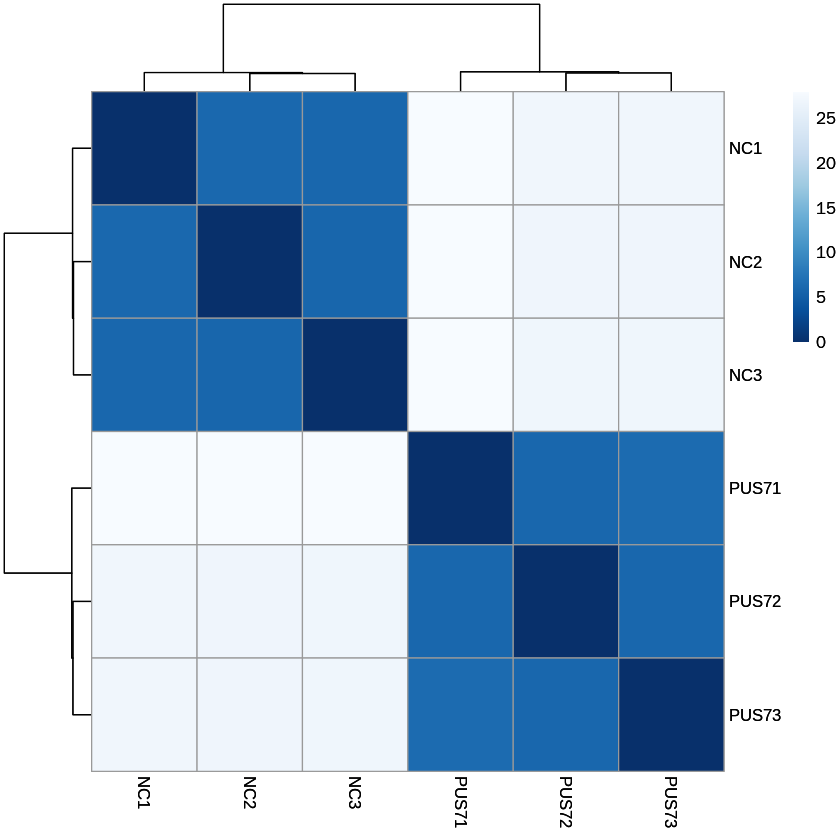

In [254]:
library(gplots)
library(pheatmap)

png("qc-heatmap-samples.png", w=1000, h=1000, pointsize=20)
# heatmap.2(sampleDistsMatrix, key=F, trace="none",
#         col=colorpanel(100, "black", "white"),
#          ColSideColors=mycols[colData$condition], RowSideColors=mycols[colData$condition],
#          margin=c(10, 10), main="Sample Distance Matrix")
colors <- colorRampPalette(rev(brewer.pal(9,"Blues")))(255)


ht <- pheatmap(sampleDistsMatrix,
               clustering_distance_cols = sampleDists,
               clustering_distance_rows = sampleDists,
               color = colors
              )
ht

In [255]:
pdf("plots/003_correlation_cross_samples_heatmap.pdf",width = 20, height = 20)
ht
dev.off()

png 
  2

14. MA plot
- log2 折叠变换和平均正常统计量的关系，红色的点表示在10%FDR的基因

In [256]:
### MA plot ------------------------------------------------------------------------------>
pdf("plots/004_DESeq2_MA_plot.pdf",width = 8, height = 8)
par(mfrow=c(1,1))
DESeq2::plotMA(res, main="DESeq2", ylim=c(-20,20))
dev.off()

png 
  2

15. nbinomTest的p值统计直方图

In [257]:
pdf("plots/005_nbinomTest_p_value.pdf",width = 8, height = 8)
hist(res$pvalue, breaks = 100, col = 'skyblue', border = 'slateblue', main = 'nbinomTest p value')
dev.off()

png 
  2

16. rld to PCA(vst is better than rlog when n>=30)

In [258]:
pdf("plots/006_PCAplot.pdf", width = 8, height = 8)
plotPCA(rld,intgroup=c("condition"))
dev.off()

png 
  2

17. 这个heatmap干嘛的？

In [259]:
library(ggplot2)
d <- plotCounts(dds,gene=which.min(res$padj), intgroup = "condition",returnData = TRUE)

In [260]:
pdf("plots/007_jitter_plot_for_min_pvalue_transcript_counts.pdf", height = 8, width = 8)
ggplot(d,aes(x=condition,y=count))+
  geom_point(position = position_jitter(w=0.1,h=0))+
  scale_y_log10(breaks=c(25,100,400))
dev.off()

png 
  2

18. 处理res数据并且输出DEG表格

In [261]:
### deal with res and extract DEG!!! ----------------------------------------------------->
# 标准cutoff
log2fc = 1  # >=1
pv = 0.05  # <=0.05
# 松cutoff
# log2fc = 1  # >=1
# pv = 1  # <=0.05


resOrdered <- res[order(res$padj),]
resOrdered[which(resOrdered$log2FoldChange >= log2fc & resOrdered$pvalue<pv), 'sig'] <- 'up'
resOrdered[which(resOrdered$log2FoldChange <= -log2fc & resOrdered$pvalue<pv),'sig'] <- 'down'
resOrdered[which(abs(resOrdered$log2FoldChange) <= log2fc & resOrdered$pvalue>=pv),'sig'] <- 'none'
resOrdered=as.data.frame(resOrdered)

write.table(resOrdered,"plots/deseq2.all_sample.results.csv",col.names = NA, sep = ",", quote = FALSE)

deg <- subset(resOrdered, (abs(resOrdered$log2FoldChange) >=log2fc & resOrdered$padj<pv)) ##### extract DEG !

deg_matrix <- as.data.frame(deg)
write.table(deg_matrix, 'plots/deg_result.csv', col.names = NA, sep = ",", quote = FALSE)


# raw count norm by deseq2
write.table(rawcts_new, 'plots/raw_counts_norm_by_DESeq2.csv', col.names = NA, sep = ",", quote = FALSE)

print(dim(deg))
deg

[1] 893   7


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
NID1,7156.9700,-1.758744,0.04146023,-42.42002,0.000000e+00,0.000000e+00,down
PDGFRB,1067.3636,-3.121412,0.07297808,-42.77191,0.000000e+00,0.000000e+00,down
TUBB,10028.0264,-1.472537,0.03526043,-41.76174,0.000000e+00,0.000000e+00,down
TOP2A,5637.9205,-1.459316,0.03841448,-37.98871,0.000000e+00,0.000000e+00,down
COL3A1,19934.2905,-1.156526,0.03267606,-35.39367,2.136638e-274,4.247992e-271,down
VGF,905.1659,-2.633453,0.07439981,-35.39596,1.969864e-274,4.247992e-271,down
NOLC1,5350.7068,1.425075,0.04102073,34.74036,1.938017e-264,3.302658e-261,up
RPL7A,9290.2701,-1.232510,0.03667248,-33.60859,1.256485e-247,1.873576e-244,down
SUCNR1,833.1696,-2.502635,0.07478417,-33.46476,1.569838e-245,2.080733e-242,down


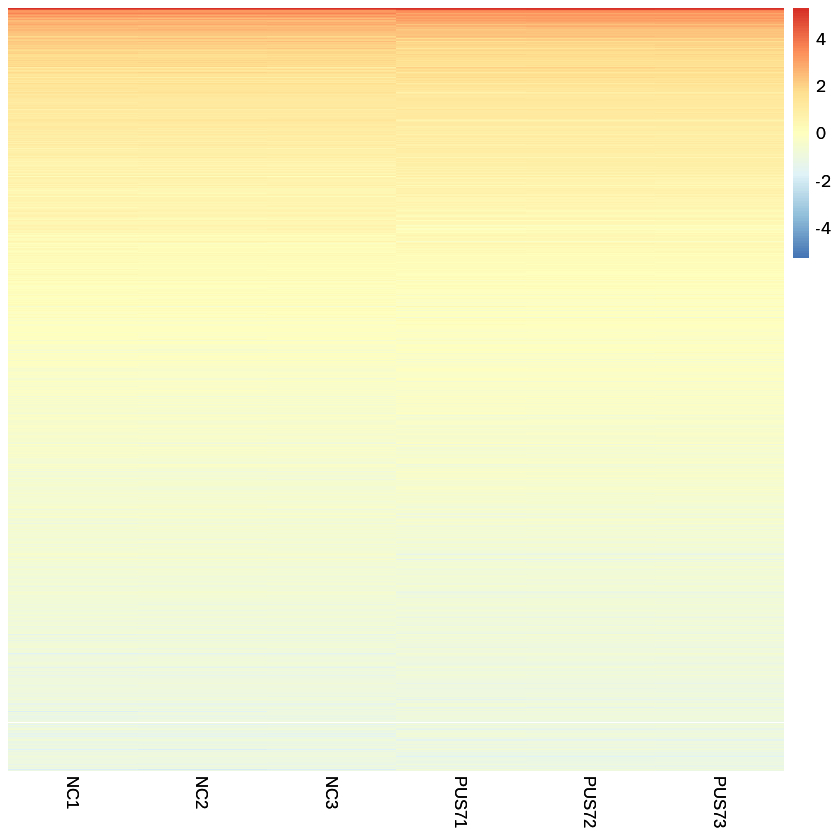

In [262]:
### plot heatmap ------------------------------------------------------------------------->
### plot all genes heatmap
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:1000]  ### select first ordered 1000 genes(not deg)
#                 decreasing=TRUE)[1:50]  ### select first ordered 66 genes(not deg)
df <- as.data.frame(colData(dds)[,c("condition")])
p1000 <- pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE,scale = "column")
p1000

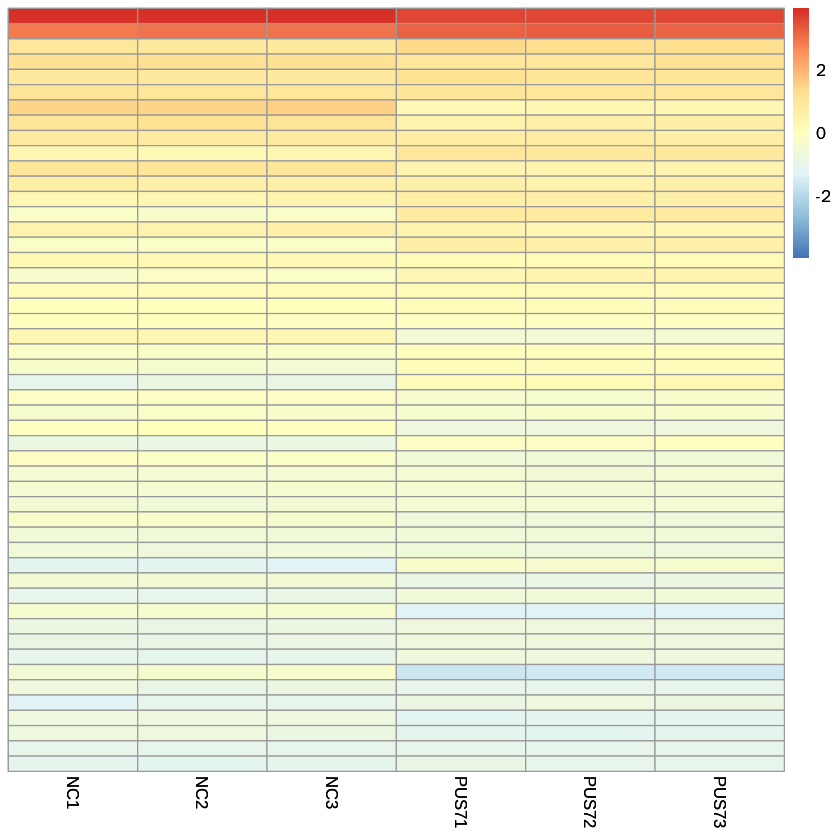

In [263]:
select <- order(rowMeans(counts(dds,normalized=TRUE)),
#                 decreasing=TRUE)[1:1000]  ### select first ordered 1000 genes(not deg)
                decreasing=TRUE)[1:50]  ### select first ordered 66 genes(not deg)
df <- as.data.frame(colData(dds)[,c("condition")])
p50 <- pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE,scale = "column")
p50

In [264]:
pdf("plots/008_select_first_ordered_1000_transcriptsOrGenes_plot_heatmap.pdf",height = 20,width = 20)
p1000
dev.off()
pdf("plots/009_select_first_ordered_50_transcriptsOrGenes_plot_heatmap.pdf",height = 20,width = 20)
p50
dev.off()

png 
  2

png 
  2

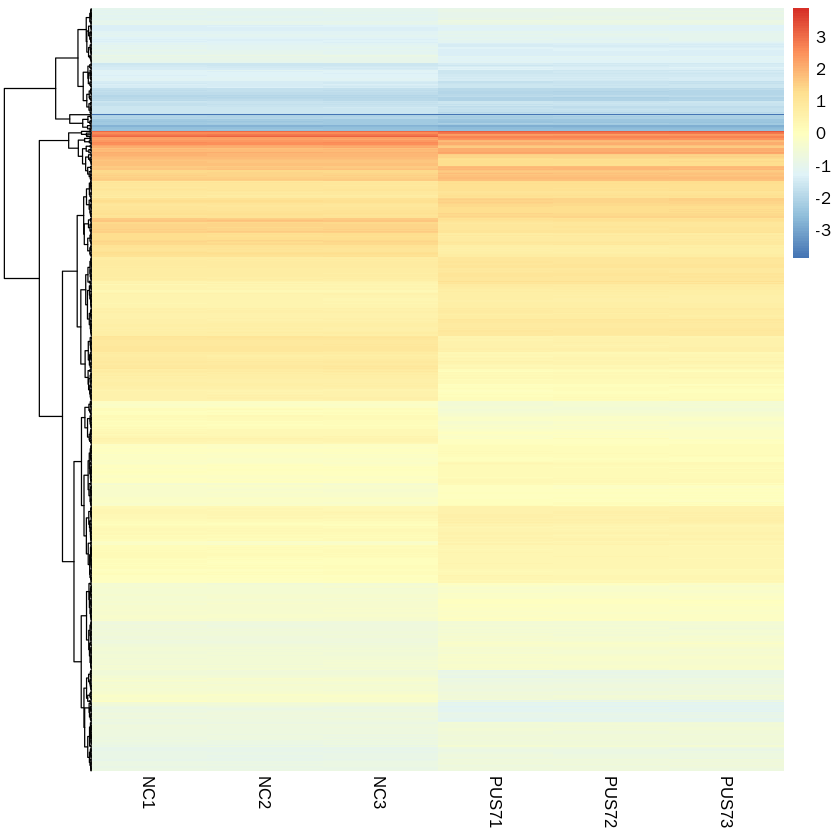

In [265]:
### plot DEG heatmap
selected <- rownames(deg)
pDEG <- pheatmap(assay(rld)[rownames(rld) %in% selected,], 
#                  cluster_rows=TRUE, 
#                  show_rownames=TRUE,
                cluster_rows=TRUE, 
                show_rownames=FALSE,
         cluster_cols=FALSE, scale = "column")

In [266]:
pdf("plots/010_select_differential_expression_genes_heatmap.pdf",height = 5,width = 20)
pDEG
dev.off()

png 
  2

In [267]:
resOrdered

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
NID1,7156.9700,-1.7587439,0.04146023,-42.42002,0.000000e+00,0.000000e+00,down
PDGFRB,1067.3636,-3.1214122,0.07297808,-42.77191,0.000000e+00,0.000000e+00,down
TUBB,10028.0264,-1.4725369,0.03526043,-41.76174,0.000000e+00,0.000000e+00,down
TOP2A,5637.9205,-1.4593165,0.03841448,-37.98871,0.000000e+00,0.000000e+00,down
COL3A1,19934.2905,-1.1565258,0.03267606,-35.39367,2.136638e-274,4.247992e-271,down
VGF,905.1659,-2.6334530,0.07439981,-35.39596,1.969864e-274,4.247992e-271,down
NOLC1,5350.7068,1.4250748,0.04102073,34.74036,1.938017e-264,3.302658e-261,up
RPL7A,9290.2701,-1.2325103,0.03667248,-33.60859,1.256485e-247,1.873576e-244,down
SUCNR1,833.1696,-2.5026346,0.07478417,-33.46476,1.569838e-245,2.080733e-242,down


Warning message:
“Removed 136 rows containing missing values (geom_point).”


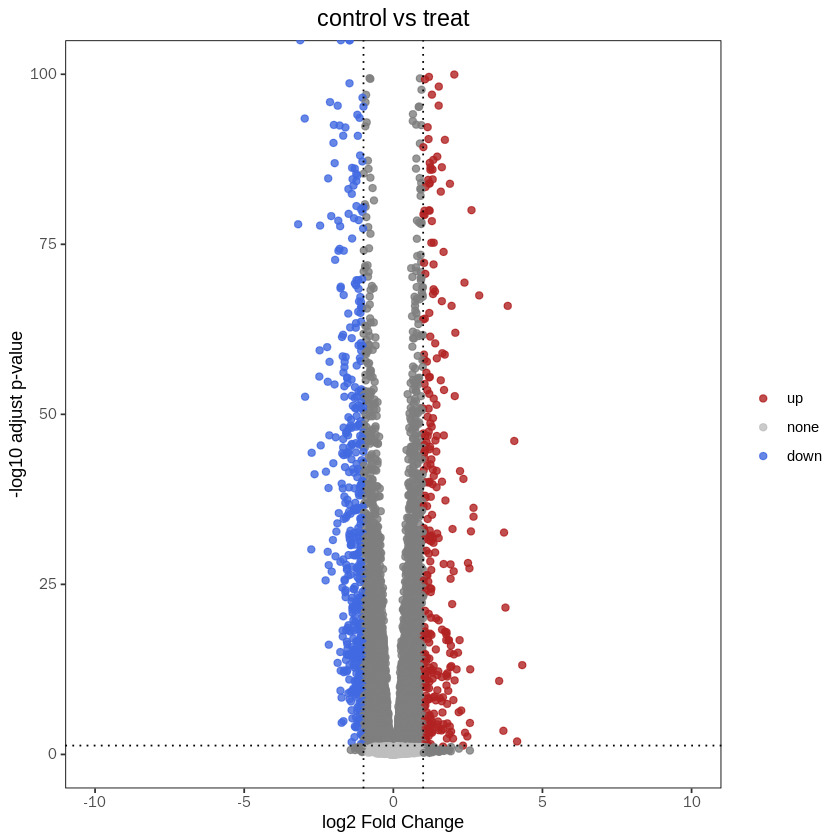

In [268]:
### plot valcano ------------------------------------------------------------------------>
vp <- ggplot(data = resOrdered, aes(x = log2FoldChange, y = -log10(padj),color = sig)) +
  geom_point(size = 1.7, alpha=0.8) +  #绘制散点图
  scale_color_manual(values = c('#B22222', 'gray', '#4169E1'), limits = c('up', 'none', 'down')) +  #自定义点的颜色
  labs(x = 'log2 Fold Change', y = '-log10 adjust p-value', title = 'control vs treat', color = '') +  #坐标轴标题
  theme(plot.title = element_text(hjust = 0.5, size = 14), panel.grid = element_blank(), #背景色、网格线、图例等主题修改
        panel.background = element_rect(color = 'black', fill = 'transparent'),
        legend.key = element_rect(fill = 'transparent')) +
  geom_vline(xintercept = c(-1, 1), lty = 3, color = 'black') +  #添加阈值线
  geom_hline(yintercept = 1.3, lty = 3, color = 'black') +
  # xlim(-2, 2) + ylim(0, 5)
  xlim(-10, 10) + ylim(0, 100)

vp

In [269]:
pdf("plots/011_select_differential_expression_genes_valcano_plot.pdf",height = 5,width = 8)
vp
dev.off()

Warning message:
“Removed 136 rows containing missing values (geom_point).”


png 
  2

# 转换所有基因名和差异表达基因名

In [129]:
library(tidyverse)

In [130]:
deg_res <- read_csv("plots/deg_result.csv")
all_res <- read_csv("plots/deseq2.all_sample.results.csv")
colnames(deg_res)

New names:
* `` -> ...1

Rows: 1164 Columns: 8

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): ...1, sig
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

New names:
* `` -> ...1

Rows: 22245 Columns: 8

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): ...1, sig
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] "...1"           "baseMean"       "log2FoldChange" "lfcSE"         
[5] "stat"           "pvalue"         "padj"           "sig"

```
git clone https://github.com/xuzhougeng/org.At.tair.db.git
cd org.At.tair.db
Rscript org.At.tair.db.R
```

In [98]:
library(AnnotationDbi)
library(org.Mm.eg.db)

ERROR: Error in library(org.Mm.eg.db): 不存在叫‘org.Mm.eg.db’这个名字的程辑包


In [5]:
deg_anno <- AnnotationDbi::mapIds(
    org.Mm.eg.db, 
    keys=as.vector(deg_res$X1), 
    column="SYMBOL", 
    keytype="ENSEMBL"
)
deg_res_final <- deg_res %>% add_column(
    deg_anno,
    .after="X1"
)
head(deg_res_final)

'select()' returned 1:many mapping between keys and columns



X1,deg_anno,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSMUSG00000029408,Abcb9,80.38315,-24.581070,2.9974166,-8.200752,2.388883e-16,3.022176e-12,down
ENSMUSG00000037049,Smpd1,141.58058,6.420548,0.8244638,7.787545,6.832394e-15,2.881221e-11,up
ENSMUSG00000025017,Pik3ap1,111.78980,6.856110,0.8763867,7.823157,5.151483e-15,2.881221e-11,up
ENSMUSG00000018983,E2f2,97.63604,7.634844,1.0049858,7.596967,3.031520e-14,9.587940e-11,up
ENSMUSG00000032125,Robo4,78.60206,-7.695032,1.0231181,-7.521157,5.429347e-14,1.373734e-10,down
ENSMUSG00000032589,Bsn,93.65185,7.634114,1.0367615,7.363423,1.792532e-13,3.779554e-10,up


In [6]:
all_anno <- AnnotationDbi::mapIds(
    org.Mm.eg.db, 
    keys=as.vector(all_res$X1), 
    column="SYMBOL", 
    keytype="ENSEMBL"
)
all_res_final <- all_res %>% add_column(
    all_anno,
    .after="X1"
)
head(all_res_final)

'select()' returned 1:many mapping between keys and columns



X1,all_anno,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sig
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSMUSG00000029408,Abcb9,80.38315,-24.581070,2.9974166,-8.200752,2.388883e-16,3.022176e-12,down
ENSMUSG00000037049,Smpd1,141.58058,6.420548,0.8244638,7.787545,6.832394e-15,2.881221e-11,up
ENSMUSG00000025017,Pik3ap1,111.78980,6.856110,0.8763867,7.823157,5.151483e-15,2.881221e-11,up
ENSMUSG00000018983,E2f2,97.63604,7.634844,1.0049858,7.596967,3.031520e-14,9.587940e-11,up
ENSMUSG00000032125,Robo4,78.60206,-7.695032,1.0231181,-7.521157,5.429347e-14,1.373734e-10,down
ENSMUSG00000032589,Bsn,93.65185,7.634114,1.0367615,7.363423,1.792532e-13,3.779554e-10,up


In [8]:
all_features <- read_tsv("all_feature_fix.csv")
head(all_features)


── Column specification ────────────────────────────────────────────────────────
cols(
  Geneid = col_character(),
  WT1 = col_double(),
  WT2 = col_double(),
  WT3 = col_double(),
  WT4 = col_double(),
  KO1 = col_double(),
  KO2 = col_double(),
  KO3 = col_double(),
  KO4 = col_double()
)




Geneid,WT1,WT2,WT3,WT4,KO1,KO2,KO3,KO4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000102693.1,0,0,0,0,0,0,0,0
ENSMUSG00000064842.1,0,0,0,0,0,0,0,0
ENSMUSG00000051951.5,0,0,0,0,0,0,0,0
ENSMUSG00000102851.1,0,0,0,0,0,0,0,0
ENSMUSG00000103377.1,0,0,0,0,0,0,0,0
ENSMUSG00000104017.1,0,0,0,0,0,0,0,0


In [63]:
head(all_features$Geneid)

[1] "ENSMUSG00000102693.1" "ENSMUSG00000064842.1" "ENSMUSG00000051951.5"
[4] "ENSMUSG00000102851.1" "ENSMUSG00000103377.1" "ENSMUSG00000104017.1"

In [67]:
### remove version in ensembl id ----------------------------------------------------------->
gn <- stringr::str_split(all_features$Geneid,"\\.",simplify = T)[,1]
all_features$Geneid <- gn
head(all_features)

Geneid,WT1,WT2,WT3,WT4,KO1,KO2,KO3,KO4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000102693,0,0,0,0,0,0,0,0
ENSMUSG00000064842,0,0,0,0,0,0,0,0
ENSMUSG00000051951,0,0,0,0,0,0,0,0
ENSMUSG00000102851,0,0,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0,0,0
ENSMUSG00000104017,0,0,0,0,0,0,0,0


In [68]:
all_features_anno <- AnnotationDbi::mapIds(
    org.Mm.eg.db, 
    keys=as.vector(all_features$Geneid), 
    column="SYMBOL", 
    keytype="ENSEMBL"
)
all_features_final <- all_features %>% add_column(
    all_features_anno,
    .after="Geneid"
)
head(all_features_final)

'select()' returned 1:many mapping between keys and columns



Geneid,all_features_anno,WT1,WT2,WT3,WT4,KO1,KO2,KO3,KO4
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000102693,NA,0,0,0,0,0,0,0,0
ENSMUSG00000064842,Gm26206,0,0,0,0,0,0,0,0
ENSMUSG00000051951,Xkr4,0,0,0,0,0,0,0,0
ENSMUSG00000102851,Gm18956,0,0,0,0,0,0,0,0
ENSMUSG00000103377,NA,0,0,0,0,0,0,0,0
ENSMUSG00000104017,NA,0,0,0,0,0,0,0,0


In [69]:
write_tsv(deg_res_final,"deg_result_symbol.tsv")
write_tsv(all_res_final,"all_result_symbol.tsv")
write_tsv(all_features_final, "all_features_symbol.tsv")